### Imports, settings, globals

In [1]:
### Set CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
from typing import Dict, List, Callable, Tuple, List
import numpy as np
import tqdm
import torch #
from torch.utils.data import DataLoader, default_collate
from torch import Tensor, nn #
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from copy import deepcopy
from typing import Dict, List, Callable, Tuple, List


import torch #
from torch.utils.data import DataLoader, default_collate
from torch import Tensor, nn #
from torchmetrics import (
    SpearmanCorrCoef, 
    AUROC,
    ROC
)
from sklearn.covariance import LedoitWolf #

# from losses import DiceScoreCalgary, DiceScoreMMS #


sys.path.append('../')
from data_utils import get_train_loader, get_eval_data
from model.unet import get_unet

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [3]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

### UNet Models

In [4]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr

#unet_name = 'monai-64-4-4'
unet_name = 'default-8'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = None if unet_name == 'swinunetr' else int(args[1])
if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])

unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda()


### Data

In [5]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = True
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = ['A']


raw_data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)


print(f'\nAvailable datasets are: {list(raw_data.keys())}')

loading dataset
loading all case properties


loading dataset
loading all case properties
loading dataset
loading all case properties

Available datasets are: ['train', 'val', 'A']


In [6]:
# get data
train_loader, val_loader = get_train_loader(
    training='unet', 
    cfg=cfg
)

loading dataset
loading all case properties


loading dataset
loading all case properties


### Old Mahalanobis Detector Code

In [7]:
from typing import Dict, List, Callable, Tuple, List


import torch #
from torch.utils.data import DataLoader, default_collate
from torch import Tensor, nn #
from torchmetrics import (
    SpearmanCorrCoef, 
    AUROC,
    ROC
)
from sklearn.covariance import LedoitWolf #

from losses import DiceScoreCalgary, DiceScoreMMS #


class PoolingMahalabonisDetector(nn.Module):
    """
    Evaluation class for OOD and ESCE tasks based on https://arxiv.org/abs/2107.05975.
    """
    
    def __init__(
        self, 
        model: nn.Module, 
        layer_ids: List[str], 
        train_loader: DataLoader, 
        valid_loader: DataLoader,
        net_out: str,
        criterion: nn.Module = DiceScoreCalgary(),
        device: str = 'cuda:0'
    ):
        super().__init__()
        self.device       = device
        self.model        = model.to(device)
        self.model.eval()
        self.layer_ids    = layer_ids
        self.train_loader = train_loader
        self.valid_loader = valid_loader
        self.net_out      = net_out
        self.criterion    = criterion
        self.pool         = nn.AvgPool3d(kernel_size=(2,2,2), stride=(2,2,2))
        self.auroc        = AUROC(task = 'binary')
        
        # Init score dict for each layer:
        self.latents   = {layer_id: [] for layer_id in self.layer_ids}
        self.mu        = {layer_id: None for layer_id in self.layer_ids}
        self.sigma_inv = {layer_id: None for layer_id in self.layer_ids}
        self.dist      = {layer_id : 0 for layer_id in self.layer_ids}
        
        self._get_latents()
        self._fit_gaussian_to_latents()
        
        
    @torch.no_grad()
    def _get_hook_fn(self, layer_id: str, mode: str = 'collect') -> Callable:
        
        def hook_fn(module: nn.Module, x: Tuple[Tensor]):
            x = x[0]
            while torch.prod(torch.tensor(x.shape[1:])) > 1e4:
                x = self.pool(x)
            x = self.pool(x)
            batch_size = x.shape[0]

            if mode == 'collect':
                self.latents[layer_id].append(x.view(batch_size, -1).detach().cpu())
            elif mode == 'single':
                self.dist[layer_id] = x.view(batch_size, -1).to(self.device)
                
        return hook_fn
    
    
    @torch.no_grad()        
    def _get_latents(self) -> None:
        handles = {}
        for layer_id in self.layer_ids:
            layer = self.model.get_submodule(layer_id)
            hook  = self._get_hook_fn(layer_id, mode='collect')
            handles[layer_id] = layer.register_forward_pre_hook(hook)

        for batch in self.train_loader:
            input_ = batch['input'].to(self.device)
            _ = self.model(input_)
                
        for layer_id in handles:
            self.latents[layer_id] = torch.cat(self.latents[layer_id], dim=0)
            handles[layer_id].remove()
        
        
    @torch.no_grad()         
    def _fit_gaussian_to_latents(self) -> None:
        for layer_id in self.layer_ids:
            self.mu[layer_id] = self.latents[layer_id].mean(0, keepdims=True).to(self.device)
            latents_centered = (self.latents[layer_id] - self.mu[layer_id].cpu()).detach().numpy()
            sigma = torch.from_numpy(LedoitWolf().fit(latents_centered).covariance_)
            self.sigma_inv[layer_id] = torch.linalg.inv(sigma).unsqueeze(0).to(self.device)
            
            
    @torch.no_grad()
    def testset_ood_detection(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        
        self.pred = {}
        self.target = {}
        
        valid_dists = {layer_id : [] for layer_id in self.layer_ids}
        for batch in self.valid_loader:
            input_ = batch['input']
            #print(input_.shape)
            if self.net_out == 'calgary':
                dist_volume = []
                for input_chunk in input_:
                    dist, _ = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    dist_volume.append(dist.copy())
                dist = default_collate(dist_volume)
            elif self.net_out == 'mms': 
                dist, _ = self.forward(input_.to(self.device))
            for layer_id in self.layer_ids:
                if self.net_out == 'calgary':
                    valid_dists[layer_id].append(dist[layer_id].mean())
                elif self.net_out == 'mms':
                    valid_dists[layer_id].append(dist[layer_id])
        self.valid_dists = valid_dists
        self.valid_labels = {layer_id: torch.zeros(len(self.valid_dists[layer_id]), dtype=torch.uint8) 
                             for layer_id in self.layer_ids}
        #print(len(self.valid_dists['up3']), len(self.valid_labels['up3']))
            
#             self.thresholds = {layer_id : 0 for layer_id in self.layer_ids}
#             for layer_id in self.layer_ids:
#                 if self.net_out == 'calgary':
#                     valid_dists[layer_id] = torch.tensor(valid_dists[layer_id]).cpu()
#                 elif self.net_out == 'mms':
#                     valid_dists[layer_id] = torch.cat(valid_dists[layer_id], dim=0).cpu()
#                 self.thresholds[layer_id] = torch.sort(valid_dists[layer_id])[0][len(valid_dists[layer_id]) - (len(valid_dists[layer_id]) // 20) - 1]
                
                    
        test_dists = {layer_id : [] for layer_id in self.layer_ids}
        for batch in test_loader:
            input_ = batch['input']
            if self.net_out == 'calgary':
                dist_volume = []
                for input_chunk in input_:
                    dist, _ = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    dist_volume.append(dist.copy())
                dist = default_collate(dist_volume)
            elif self.net_out == 'mms': 
                dist, _ = self.forward(input_.to(self.device))
            for layer_id in self.layer_ids:
                if self.net_out == 'calgary':
                    test_dists[layer_id].append(dist[layer_id].mean())
                elif self.net_out == 'mms':    
                    test_dists[layer_id].append(dist[layer_id])
        
        self.test_dists = test_dists
        self.test_labels = {layer_id: torch.ones(len(self.test_dists[layer_id]), dtype=torch.uint8) 
                             for layer_id in self.layer_ids}
            
            
        AUROC = {layer_id : 0 for layer_id in self.layer_ids}
        for layer_id in self.layer_ids:
            if self.net_out == 'calgary':
                self.valid_dists[layer_id] = torch.tensor(self.valid_dists[layer_id]).cpu()
                self.test_dists[layer_id]  = torch.tensor(self.test_dists[layer_id]).cpu()
            elif self.net_out == 'mms':
                self.valid_dists[layer_id] = torch.cat(self.valid_dists[layer_id], dim=0).cpu()
                self.test_dists[layer_id]  = torch.cat(self.test_dists[layer_id], dim=0).cpu()
            self.pred[layer_id]   = torch.cat([self.valid_dists[layer_id], self.test_dists[layer_id]]).squeeze()
            self.target[layer_id] = torch.cat([self.valid_labels[layer_id], self.test_labels[layer_id]]).squeeze()
            
            print(self.pred[layer_id].shape, self.target[layer_id].shape)
            
            AUROC[layer_id] = self.auroc(self.pred[layer_id], self.target[layer_id])
            #accuracy[layer_id] = ((test_dists[layer_id] > self.thresholds[layer_id]).sum() / len(test_dists[layer_id]))
                
        return AUROC
    
    
    
    @torch.no_grad()        
    def testset_correlation(self, test_loader: DataLoader) -> Dict[str, torch.Tensor]:
        corr_coeffs = {layer_id: SpearmanCorrCoef() for layer_id in self.layer_ids}
        for batch in test_loader:
            input_ = batch['input']
            target = batch['target']
            if self.net_out == 'calgary':
                dist_volume = []
                net_out_volume = []
                for input_chunk in input_:
                    dist, net_out = self.forward(input_chunk.unsqueeze(0).to(self.device))
                    dist_volume.append(dist.copy())
                    net_out_volume.append(net_out.cpu())
                dist = default_collate(dist_volume)            
                net_out = torch.cat(net_out_volume, dim=0)
            
            if self.net_out == 'mms':
                target[target == -1] = 0
                # convert to one-hot encoding
                target = F.one_hot(target.long(), num_classes=4).squeeze(1).permute(0,3,1,2)
                dist, net_out = self.forward(input_.to(self.device))            
            loss = self.criterion(net_out.cpu(), target)

            loss = loss.mean().float().cpu()
            for layer_id in self.layer_ids:
                corr_coeffs[layer_id].update(dist[layer_id].cpu().mean().view(1), 1-loss.view(1))

        return corr_coeffs


    @torch.no_grad()  
    def forward(self, input_: torch.Tensor) -> torch.Tensor:
        
        handles = {}
        for layer_id in self.layer_ids:
            layer = self.model.get_submodule(layer_id)
            hook  = self._get_hook_fn(layer_id, mode='single')
            handles[layer_id] = layer.register_forward_pre_hook(hook)
        
        net_out = self.model(input_)
        
        for layer_id in self.layer_ids:
            latent_centered = self.dist[layer_id].view(self.dist[layer_id].shape[0], 1, -1) - \
                self.mu[layer_id].unsqueeze(0)
            self.dist[layer_id] = latent_centered @ self.sigma_inv[layer_id] @ \
                latent_centered.permute(0,2,1)
            handles[layer_id].remove()
            
        return self.dist, net_out
    

### Refactor Mahalanobis Detection  


class Adapter:

    attr:
        swivel
        hook_type: forward or backward
    
    methods:
        


class Transformation:


    methods:
        transform (forward ?)
        score (mahalanobis or log likelihood https://stats.stackexchange.com/questions/97408/relation-of-mahalanobis-distance-to-log-likelihood)

In [35]:
class PoolingMahalanobisDetector(nn.Module):
    def __init__(
        self,
        swivel:     str,
        sigma_algorithm: str = 'default',
        # hook_fn:    str  = 'pre',
        transform:  bool = False,
        lr:         float = 1e-3,
        device:     str  = 'cuda:0'
    ):
        super().__init__()
        # init args
        self.swivel = swivel
        self.sigma_algorithm = sigma_algorithm
        # self.hook_fn = self.register_forward_pre_hook if hook_fn == 'pre' else self.register_forward_hook
        self.transform = transform
        self.lr = lr
        self.device = device
        # other attributes
        self.training_representations = []
        # methods
        self._pool = nn.AvgPool2d(kernel_size=(2,2), stride=(2,2))
        self.to(device)


    ### private methods ###

    def _reduce(self, x: Tensor) -> Tensor:
        # reduce dimensionality with 3D pooling to below 1e4 entries
        while torch.prod(torch.tensor(x.shape[1:])) > 1e4:
            x = self._pool(x)
        x = self._pool(x)
        # reshape to (batch_size, 1, n_features)
        x = x.reshape(x.shape[0], 1, -1)
        return x


    @torch.no_grad()
    def _collect(self, x: Tensor) -> None:
        # reduces dimensionality, moves to cpu and stores
        
        x = self._reduce(x.detach()).cpu()
        self.training_representations.append(x)


    @torch.no_grad()
    def _merge(self) -> None:
        # concatenate batches from training data
        self.training_representations = torch.cat(
            self.training_representations,
            dim=0
        )


    @torch.no_grad()
    def _estimate_gaussians(self) -> None:
        self.mu = self.training_representations.mean(0, keepdims=True).detach().to(self.device)
        if self.sigma_algorithm == 'ledoitWolf':
            self.register_buffer(
                'sigma', 
                torch.from_numpy(
                    LedoitWolf().fit(
                        self.training_representations.squeeze(1)
                    ).covariance_
                )
            )
        elif self.sigma_algorithm == 'diagonal':
            self.register_buffer(
                'sigma',
                torch.var(self.training_representations.squeeze(1), dim=0).diag(0)
            )
        elif self.sigma_algorithm == 'default':
            self.register_buffer(
                'sigma',
                torch.cov(self.training_representations.squeeze(1).T)
            )
        else:
            raise NotImplementedError('Choose from: lediotWolf, diagonal, default')

        self.register_buffer(
            'sigma_inv', 
            torch.linalg.inv(self.sigma).detach().unsqueeze(0).to(self.device)
        )


    def _distance(self, x: Tensor) -> Tensor:
        assert self.sigma_inv is not None, 'fit the model first'
        # assert self.device == x.device, 'input and model device must match'
        x_reduced  = self._reduce(x)
        x_centered = x_reduced - self.mu
        dist       = x_centered @ self.sigma_inv @ x_centered.permute(0,2,1)

        return torch.sqrt(dist)


    ### public methods ###

    def fit(self):
        self._merge()
        self._estimate_gaussians()
        del self.training_representations


    def forward(self, x: Tensor) -> Tensor:
        # implements identity function from a hooks perspective
        if self.training:
            self._collect(x)
        
        else:
            self.batch_distances = self._distance(x).detach().view(-1)
            if self.transform:
                x = x.clone().detach().requires_grad_(True)
                dist = self._distance(x).mean()
                dist.backward()
                x.data.sub_(self.lr * x.grad.data)
                x.grad.data.zero_()
                x.requires_grad = False

        return x


    
class PoolingMahalanobisWrapper(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        adapters: nn.ModuleList,
        copy: bool = True,
    ):
        super().__init__()
        self.model           = deepcopy(model) if copy else model
        self.adapters        = adapters
        self.adapter_handles = {}


    def hook_adapters(
        self,
    ) -> None:
        for adapter in self.adapters:
            swivel = adapter.swivel
            layer  = self.model.get_submodule(swivel)
            hook   = self._get_hook(adapter)
            self.adapter_handles[
                swivel
            ] = layer.register_forward_pre_hook(hook)


    def _get_hook(
        self,
        adapter: nn.Module
    ) -> Callable:
        def hook_fn(
            module: nn.Module, 
            x: Tuple[Tensor]
        ) -> Tensor:
            x, *_ = x # tuple, alternatively use x_in = x[0]
            x = adapter(x)
            return x
        
        return hook_fn

    def forward(
        self, 
        x: Tensor
    ) -> Tensor:
        return self.model(x)



In [ ]:
class PixelMahalanobisDetector(nn.Module):
    def __init__(
        self,
        swivel:     str,
        sigma_algorithm: str = 'default',
        # hook_fn:    str  = 'pre',
        transform:  bool = False,
        lr:         float = 1e-3,
        device:     str  = 'cuda:0'
    ):
        super().__init__()
        # init args
        self.swivel = swivel
        self.sigma_algorithm = sigma_algorithm
        # self.hook_fn = self.register_forward_pre_hook if hook_fn == 'pre' else self.register_forward_hook
        self.transform = transform
        self.lr = lr
        self.device = device
        # other attributes
        self.training_representations = []
        # methods
        self.to(device)
    

    ### private methods ###

    def _reduce(self, x: Tensor) -> Tensor:
        # reshape to (batch_size, 1, n_features)
        x = x.reshape(x.shape[0], 1, -1)
        return x


    @torch.no_grad()
    def _collect(self, x: Tensor) -> None:
        # reduces dimensionality, moves to cpu and stores
        x = self._reduce(x.detach()).cpu()
        self.training_representations.append(x)


    @torch.no_grad()
    def _merge(self) -> None:
        # concatenate batches from training data
        self.training_representations = torch.cat(
            self.training_representations,
            dim=0
        )




    @torch.no_grad()
    def _estimate_gaussians(self) -> None:
        self.mu = self.training_representations.mean(0, keepdims=True).detach().to(self.device)
        if self.sigma_algorithm == 'ledoitWolf':
            self.register_buffer(
                'sigma', 
                torch.from_numpy(
                    LedoitWolf().fit(
                        self.training_representations.squeeze(1)
                    ).covariance_
                )
            )
        elif self.sigma_algorithm == 'diagonal':
            self.register_buffer(
                'sigma',
                torch.var(self.training_representations.squeeze(1), dim=0).diag(0)
            )
        elif self.sigma_algorithm == 'default':
            self.register_buffer(
                'sigma',
                torch.cov(self.training_representations.squeeze(1).T)
            )
        else:
            raise NotImplementedError('Choose from: lediotWolf, diagonal, default')

        self.register_buffer(
            'sigma_inv', 
            torch.linalg.inv(self.sigma).detach().unsqueeze(0).to(self.device)
        )


    def _distance(self, x: Tensor) -> Tensor:
        assert self.sigma_inv is not None, 'fit the model first'
        # assert self.device == x.device, 'input and model device must match'
        x_reduced  = self._reduce(x)
        x_centered = x_reduced - self.mu
        dist       = x_centered @ self.sigma_inv @ x_centered.permute(0,2,1)

        return torch.sqrt(dist)
    

    ### public methods ###

    def fit(self):
        self._merge()
        self._estimate_gaussians()
        del self.training_representations


    def forward(self, x: Tensor) -> Tensor:
        # implements identity function from a hooks perspective
        if self.training:
            self._collect(x)
        
        else:
            self.batch_distances = self._distance(x).detach().view(-1)
            if self.transform:
                x = x.clone().detach().requires_grad_(True)
                dist = self._distance(x).mean()
                dist.backward()
                x.data.sub_(self.lr * x.grad.data)
                x.grad.data.zero_()
                x.requires_grad = False

        return x



In [36]:
# examples and debugging
device = 'cuda:0'

detector = PoolingMahalanobisDetector(
    swivel='up3.0.conv_path.0.bn',
    device=device,
    sigma_algorithm='default'
)
detector.train()
wrapper = PoolingMahalanobisWrapper(
    model=unet,
    adapters=nn.ModuleList([detector])
)

wrapper.hook_adapters()

loaders = {
    domain: DataLoader(
        raw_data[domain], 
        batch_size=32, 
        shuffle=False, 
        drop_last=False
    ) for domain in raw_data
}

In [37]:
for _ in tqdm.tqdm(range(10)):
    batch = next(train_loader)
    x = batch['data'].to(device)
    _ = wrapper(x)
detector.fit()

100%|██████████| 10/10 [00:00<00:00, 13.50it/s]


torch.Size([1024, 320])
torch.Size([1024, 1024]) tensor([[0.0136, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0287, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0470,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0392, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0372, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0366]])


In [19]:
# for batch in loaders['train']:
#     x = batch['input'].to(device)
#     _ = wrapper(x)
# detector.fit()

In [59]:
detector.eval()
metrics = {domain: [] for domain in raw_data}
metrics['true_train'] = []
for _ in tqdm.tqdm(range(100)):
    batch = next(train_loader)
    x = batch['data'].to(device)
    _ = wrapper(x)
    metrics['true_train'].append(detector.batch_distances.squeeze().cpu())

metrics['true_val'] = []
for _ in tqdm.tqdm(range(100)):
    batch = next(val_loader)
    x = batch['data'].to(device)
    _ = wrapper(x)
    metrics['true_val'].append(detector.batch_distances.squeeze().cpu())

for domain in raw_data:
    for batch in loaders[domain]:
        x = batch['input'].to(device)
        _ = wrapper(x)
        metrics[domain].append(detector.batch_distances.squeeze().cpu())
for domain in metrics:
    metrics[domain] = torch.cat(metrics[domain], dim=0)

        

100%|██████████| 100/100 [00:39<00:00,  2.55it/s]


In [61]:
metrics['true_val'] = []
for _ in tqdm.tqdm(range(100)):
    batch = next(val_loader)
    x = batch['data'].to(device)
    _ = wrapper(x)
    metrics['true_val'].append(detector.batch_distances.squeeze().cpu())

metrics['true_val'] = torch.cat(metrics['true_val'], dim=0)

100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


In [62]:
print('Domain     Distance')
for domain in metrics:
    print(
        f'{domain.ljust(10)} {metrics[domain].mean().item():.3f}'
    )

Domain     Distance
train      32.568
val        34.559
A          44.072
true_train 34.044
true_val   33.816


### Batch Norm Mahalanobis / Log Likelihood

In [8]:

loaders = {
    domain: DataLoader(
        raw_data[domain], 
        batch_size=32, 
        shuffle=False, 
        drop_last=False
    ) for domain in raw_data
}

In [9]:
def get_batchnorm_mahalanobis_detector(
    swivels: List[str],
    unet:    nn.Module = None,
    reduce: bool = True,
    aggregate: str = 'mean',
    transform: bool = False,
    lr: float = 1e-3,
    device:  str  = 'cuda:0'
):
    batchnorm_detector = [
        BatchNormMahalanobisDetector(
            swivel=swivel,
            reduce=reduce,
            aggregate=aggregate,
            transform=transform,
            lr=lr,
            device=device,
        ) for swivel in swivels
    ]
    batchnorm_wrapper = BatchNormMahalanobisWrapper(
        model=unet,
        adapters=nn.ModuleList(batchnorm_detector),
    )
    batchnorm_wrapper.hook_adapters()
    batchnorm_wrapper.to(device)
    batchnorm_wrapper.eval()
    
    return batchnorm_wrapper



class BatchNormMahalanobisDetector(nn.Module):
    def __init__(
        self,
        swivel:    str,
        reduce: bool = True,
        aggregate: str = 'mean',
        transform: bool = False,
        lr: float = 1e-3,
        device:    str  = 'cuda:0'
    ):
        super().__init__()
        # init args
        self.swivel = swivel
        self.reduce = reduce
        self.aggregate = aggregate
        self.lr = lr
        self.transform = transform
        self.device = device
        self.to(device)

    ### private methods ###
    
    def _reduce(
        self, 
        x: Tensor
    ) -> Tensor:
        if self.aggregate == 'mean':
            x = x.mean(dim=(2,3)).unsqueeze(1)
        elif self.aggregate == 'max':
            x = (x - self.mu.view((1, -1, 1, 1)).abs())
            x = x.amax(dim=(2,3)).unsqueeze(1)
        else:
            raise NotImplementedError(f'{self.aggregate} not implemented, choose from: [mean, max]')

        return x


    def _distance(
        self, 
        x: Tensor
    ) -> Tensor:
        x = self._reduce(x)
        x = (x - self.mu)**2
        dist = (x * self.sigma_inv)
        if self.reduce:
            dist = torch.sqrt(dist.sum(dim=(1,2), keepdim=True))
        return dist


    ### public methods ###
    @torch.no_grad()
    def store_bn_params(
        self,
        params
    ) -> None:
        self.register_buffer('mu', params.running_mean.detach().unsqueeze(0).to(self.device))
        self.register_buffer('var', params.running_var.detach().unsqueeze(0).to(self.device))
        self.register_buffer('sigma_inv', 1 / torch.sqrt(self.var))
        # self.mu  = params.running_mean.detach().unsqueeze(0).to(self.device)
        # self.var = params.running_var.detach().unsqueeze(0).to(self.device)
        # self.sigma_inv = 1 / torch.sqrt(self.var)


    def forward(
        self, 
        x: Tensor
    ) -> Tensor:
        # implements identity function from a hooks perspective

        x_tmp = x.clone().detach()
        if self.training:
            pass
        else:
            if self.reduce:
                self.batch_distances = self._distance(x).detach().cpu().view(-1)
            else:
                self.batch_distances = self._distance(x).detach().cpu().view(x.shape[0], -1)
        
        if self.transform:
            # x.detach()
            # x.requires_grad = True
            # x = torch.tensor(x.data, requires_grad=True, device=x.device)
            # x_tmp = x.clone().detach().requires_grad_(False)
            x = x.clone().detach().requires_grad_(True)
            dist = self._distance(x).mean()
            
            dist.backward()
            # print('Before:', dist.data.mean())
            # print(x.grad.data.sum(), x.mean(), x.grad.data.mean())
            x.data.sub_(self.lr * x.grad.data)
            x.grad.data.zero_()
            x.requires_grad = False
            # print('After:', self._distance(x).data.mean())
            # print((x_tmp - x).sum(), (x_tmp - x).mean())


        print(torch.allclose(x, x_tmp))
        return x
        


class BatchNormMahalanobisWrapper(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        adapters: nn.ModuleList,
        copy: bool = True,
    ):
        super().__init__()
        self.model           = deepcopy(model) if copy else model
        self.adapters        = adapters
        self.adapter_handles = {}
        self.model.eval()


    def hook_adapters(
        self,
    ) -> None:
        for adapter in self.adapters:
            swivel = adapter.swivel
            layer  = self.model.get_submodule(swivel)
            adapter.store_bn_params(layer)
            hook = self._get_hook(adapter)
            self.adapter_handles[
                swivel
            ] = layer.register_forward_pre_hook(hook)


    def _get_hook(
        self,
        adapter: nn.Module
    ) -> Callable:
        def hook_fn(
            module: nn.Module, 
            x: Tuple[Tensor]
        ) -> Tensor:
            # x, *_ = x # tuple, alternatively use x_in = x[0]
            # x = adapter(x)
            # return x
            return adapter(x[0]) 
        
        return hook_fn


    def aggregate_adapter_scores(self):
        scores_raw = torch.cat(
            [adapter.batch_distances for adapter in self.adapters],
            dim=1
        )
        scores_aggregated = scores_raw.sum(1).sqrt()

        return scores_aggregated
    

    def set_transform(self, transform: bool):
        for adapter in self.adapters:
            adapter.transform = transform


    def forward(
        self, 
        x: Tensor
    ) -> Tensor:
        return self.model(x)



In [12]:
device = 'cuda:0'
bn_layer = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]
# bn_layer = [bn_layer[len(bn_layer)//2]]
# bn_layer = ['up3.0.conv_path.0.bn']
batchnorm_wrapper = get_batchnorm_mahalanobis_detector(
    swivels=bn_layer,
    unet=unet,
    reduce=False,
    aggregate='mean',
    transform=False,
    lr=3e5,
    device=device
)

In [14]:
for batch in loaders['A']:
    x = batch['input'].to(device)
    target = batch['target'].squeeze(1).long()
    target[target == -1] = 0

    batchnorm_wrapper.transfrom = False
    print(batchnorm_wrapper.transform)
    _ = batchnorm_wrapper(x)
    batchnorm_wrapper.transfrom = True
    print(batchnorm_wrapper.transform)
    _ = batchnorm_wrapper(x)

    break

AttributeError: 'BatchNormMahalanobisWrapper' object has no attribute 'transform'

In [163]:
unet_dscs = []
transformation_dscs = []

for batch in loaders['A']:
    x = batch['input'].to(device)
    target = batch['target'].squeeze(1).long()
    target[target == -1] = 0
    out_unet = torch.argmax(unet(x), dim=1).cpu()
    out_transformed = torch.argmax(batchnorm_wrapper(x), dim=1).cpu()

    unet_dscs.append(
        dice(
            out_unet.flatten(), 
            target.flatten(),
            num_classes=4,
            zero_division=0,
            average='macro'
        )
    )

    transformation_dscs.append(
        dice(
            out_transformed.flatten(), 
            target.flatten(),
            num_classes=4,
            zero_division=0,
            average='macro'
        )
    )

print(
    f'UNet DSC: {torch.tensor(unet_dscs).mean():.3f},'
    f'Transformation DSC: {torch.tensor(transformation_dscs).mean():.3f}'
)


RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated

In [166]:
print(
    f'UNet DSC: {torch.tensor(unet_dscs).mean():.3f},'
    f'Transformation DSC: {torch.tensor(transformation_dscs).mean():.3f}'
)

UNet DSC: 0.879,Transformation DSC: 0.886


In [ ]:
dice(
    out_unet.flatten(), 
    target.flatten(),
    num_classes=4,
    zero_division=1,
    average='macro'
)

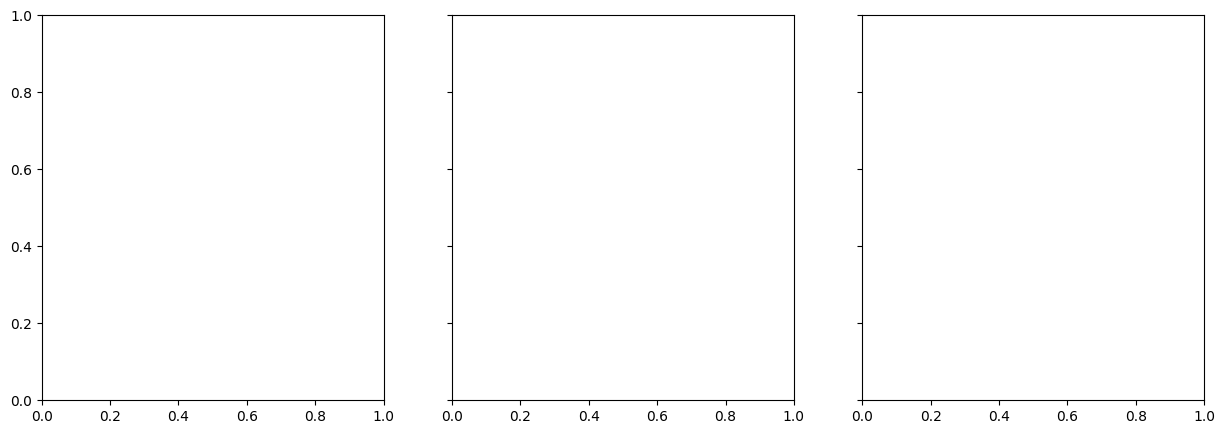

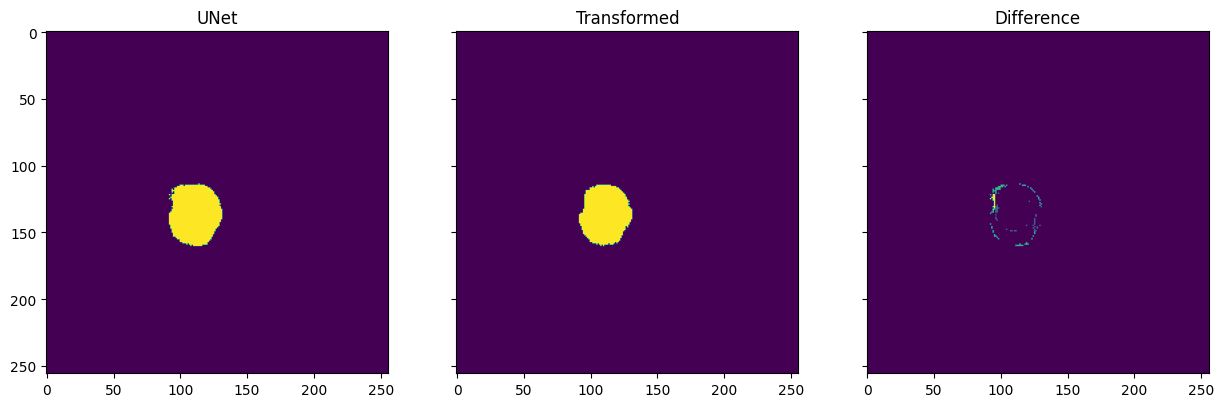

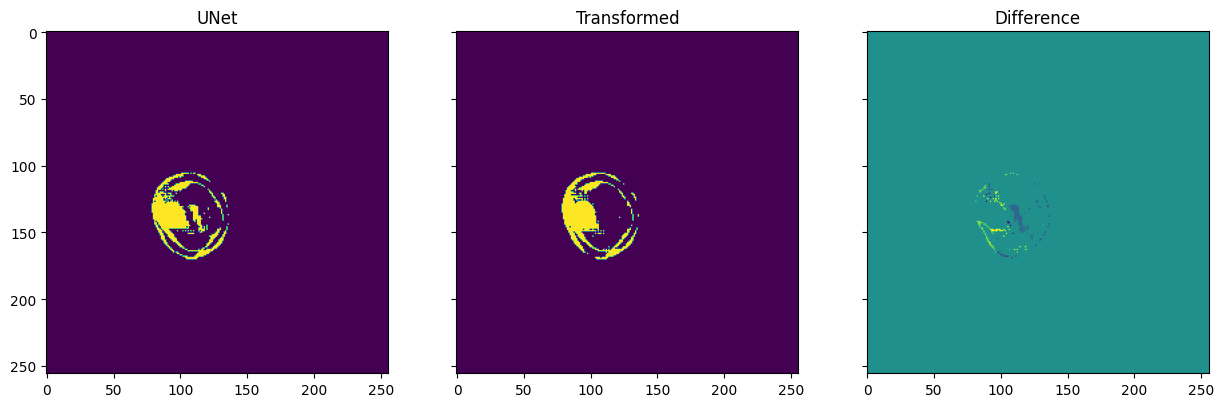

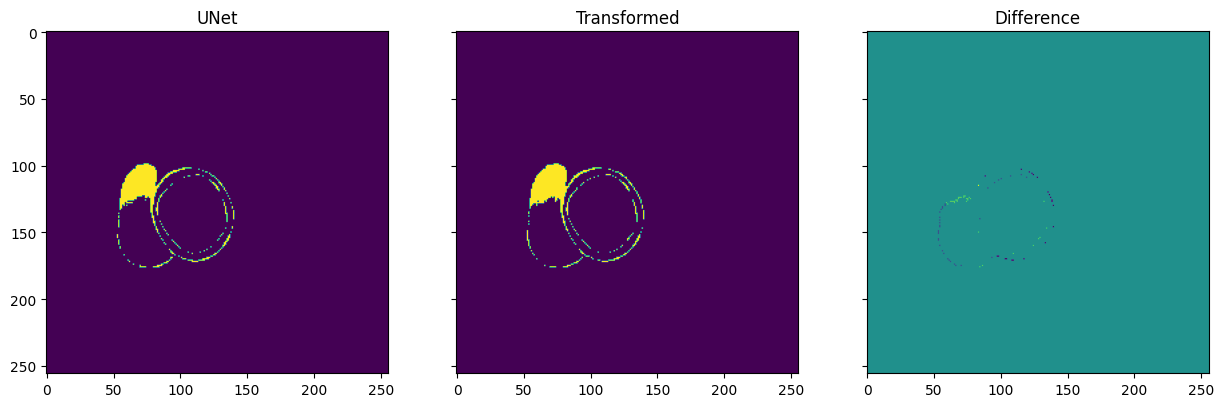

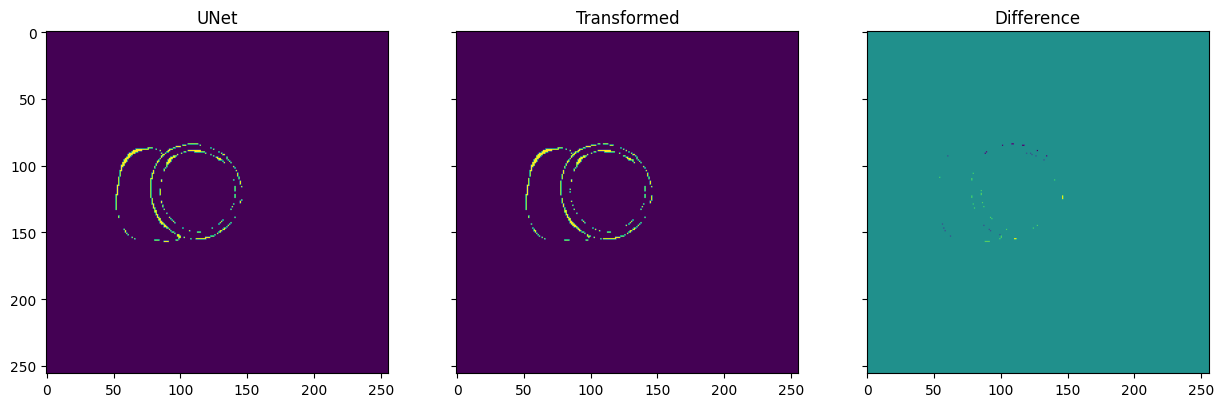

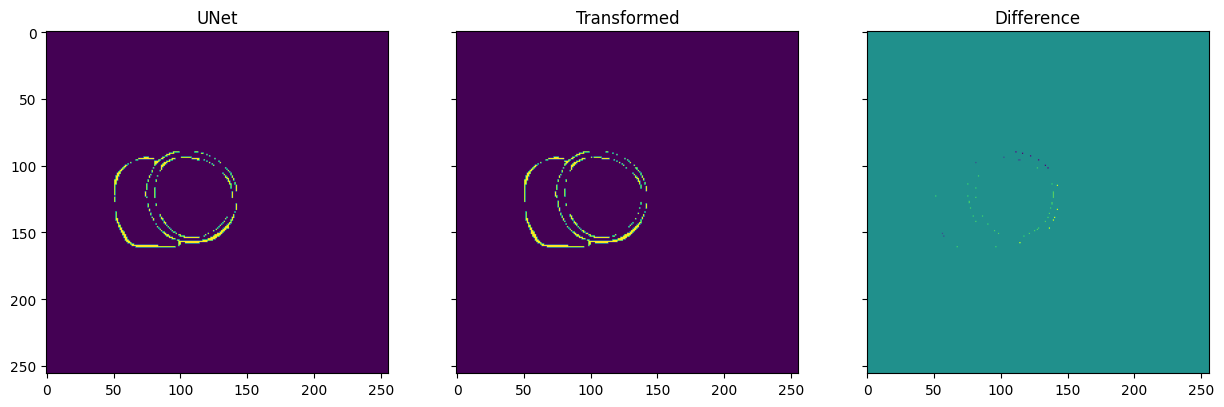

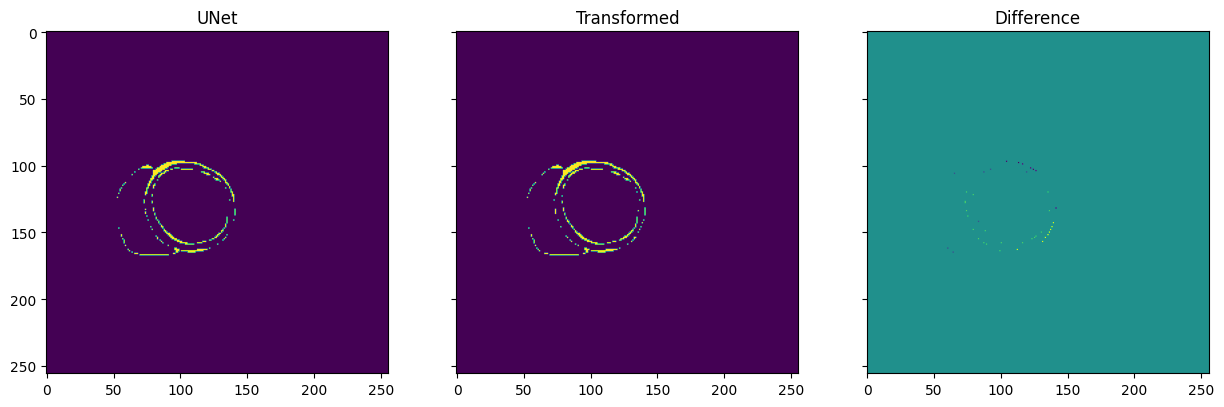

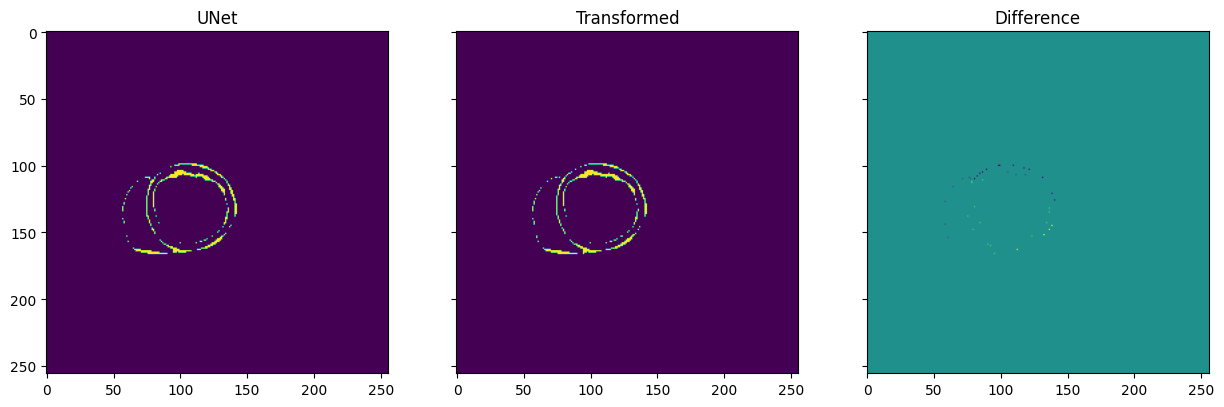

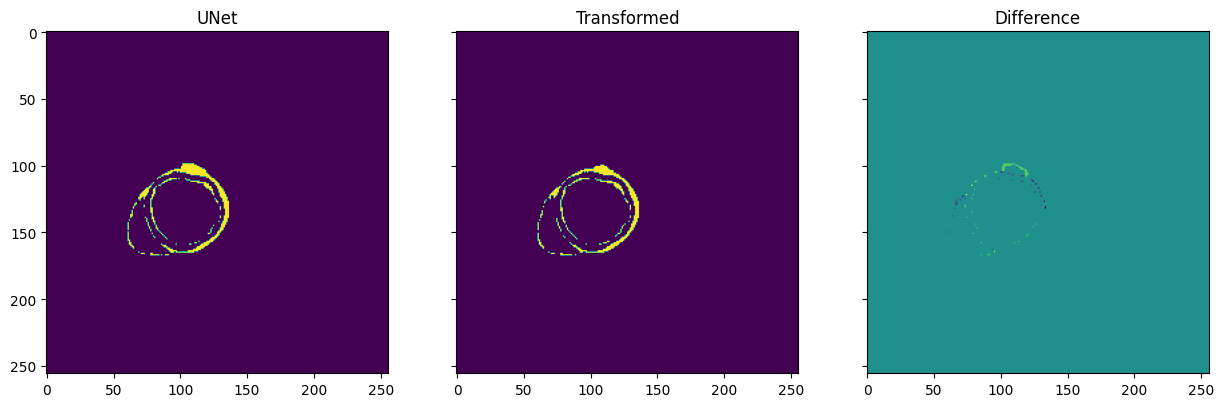

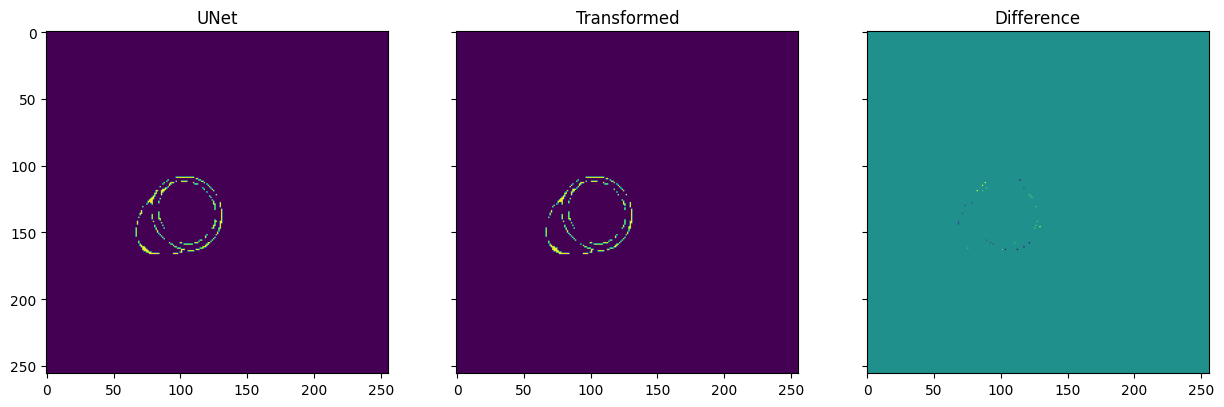

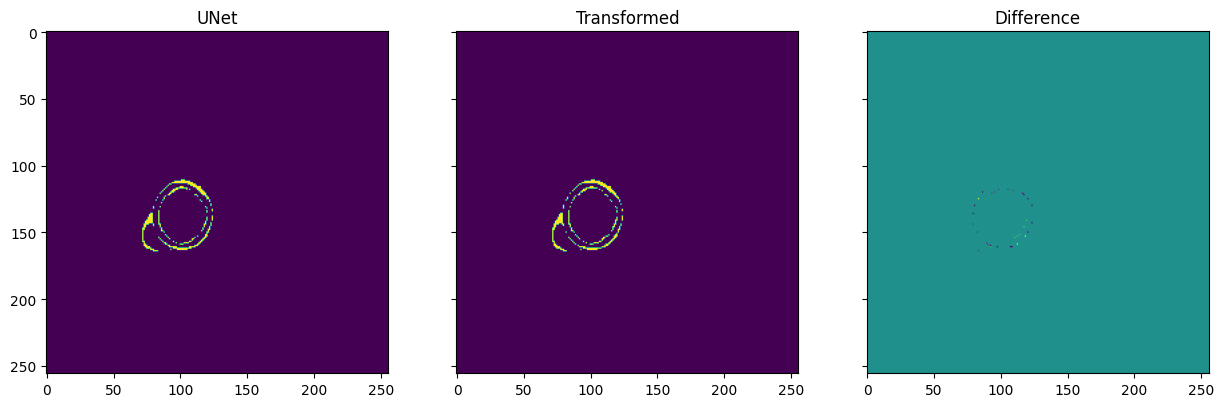

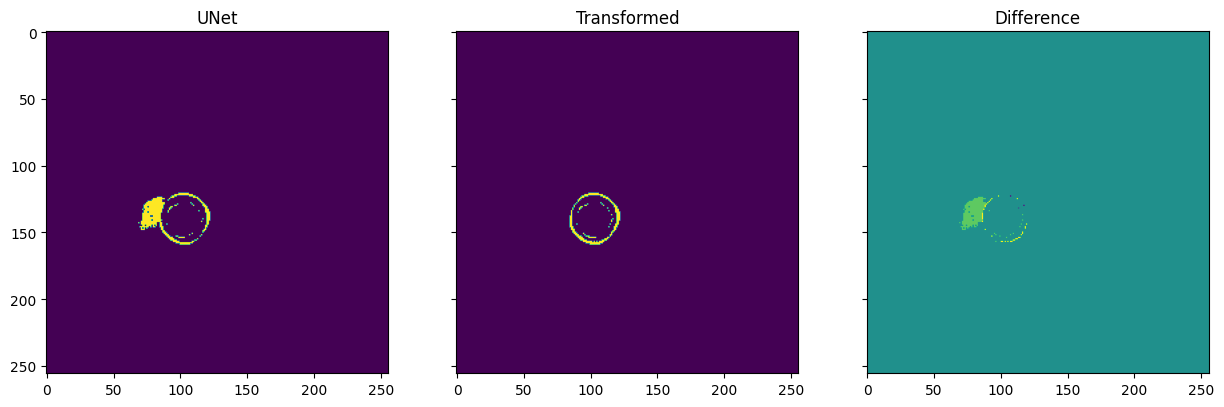

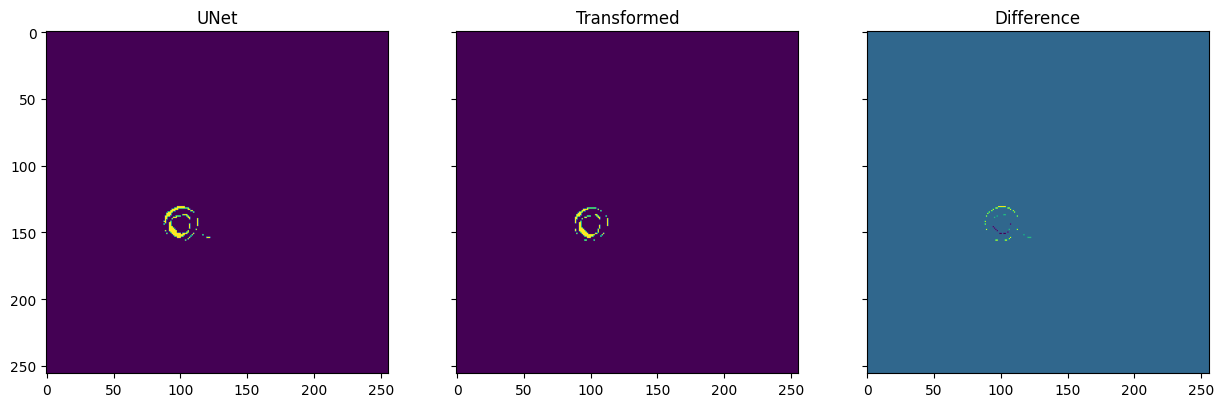

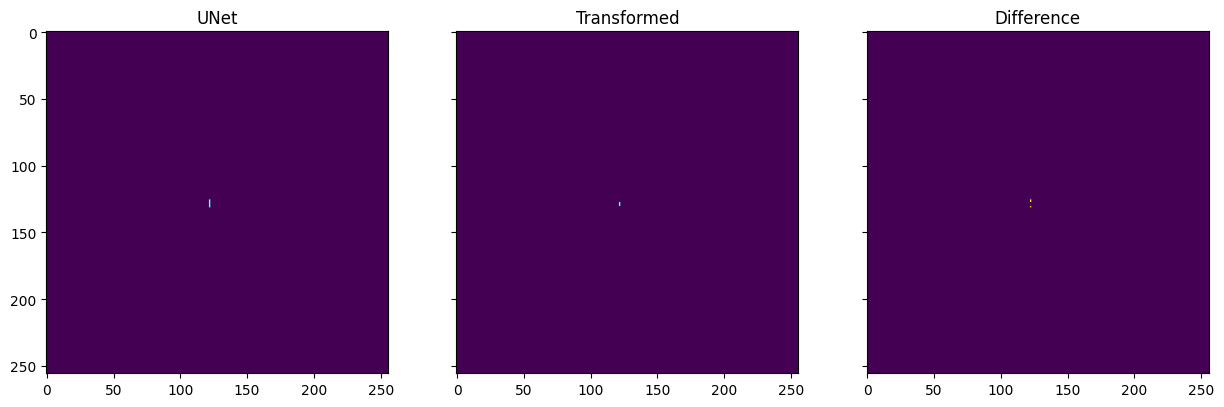

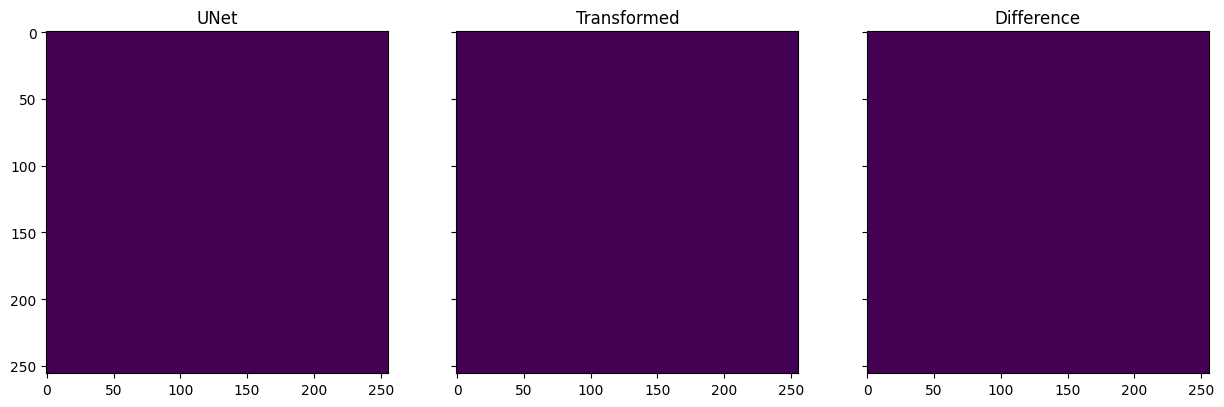

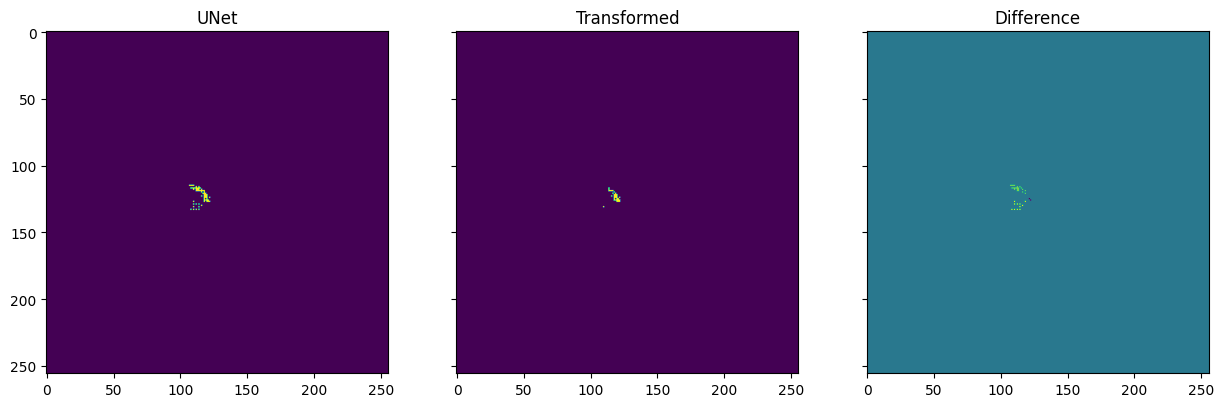

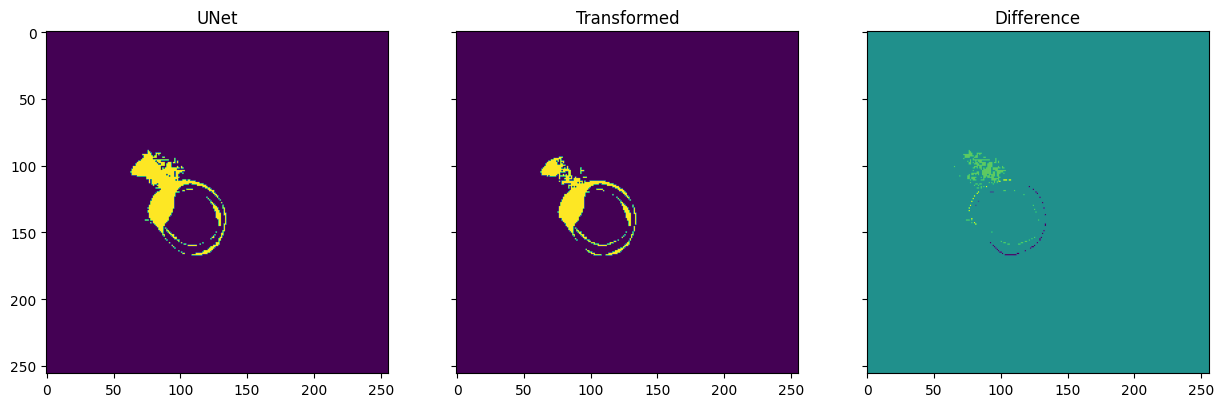

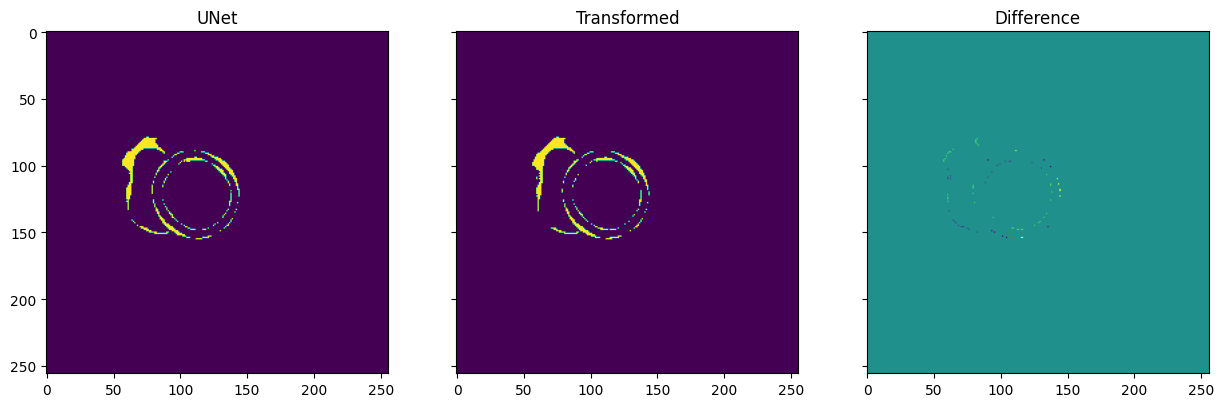

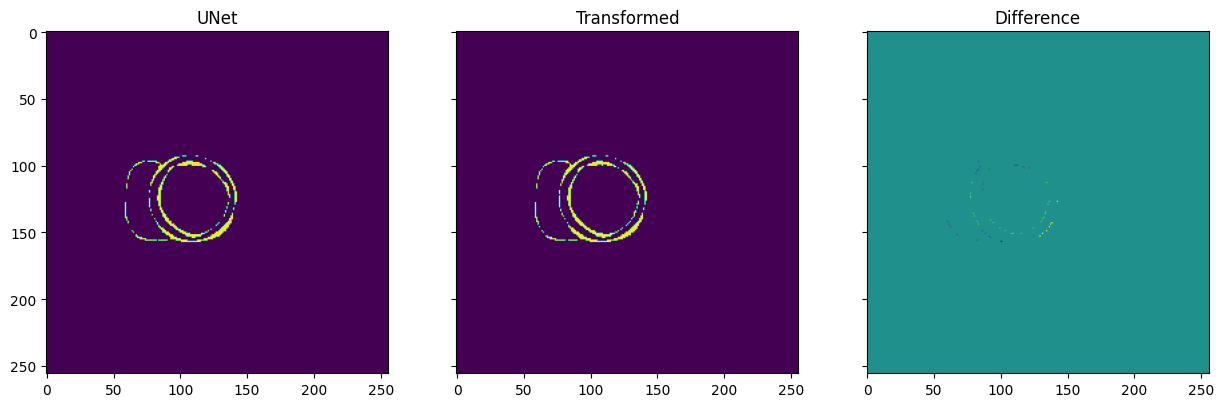

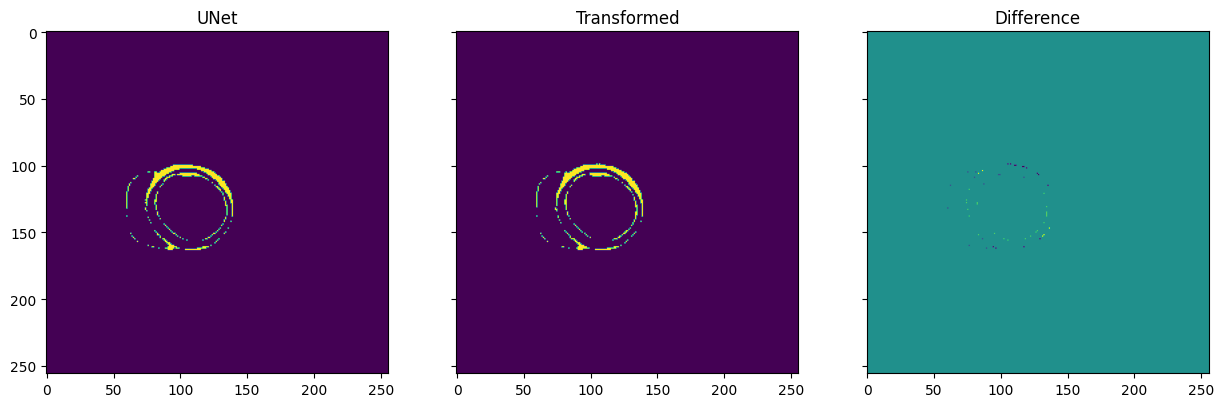

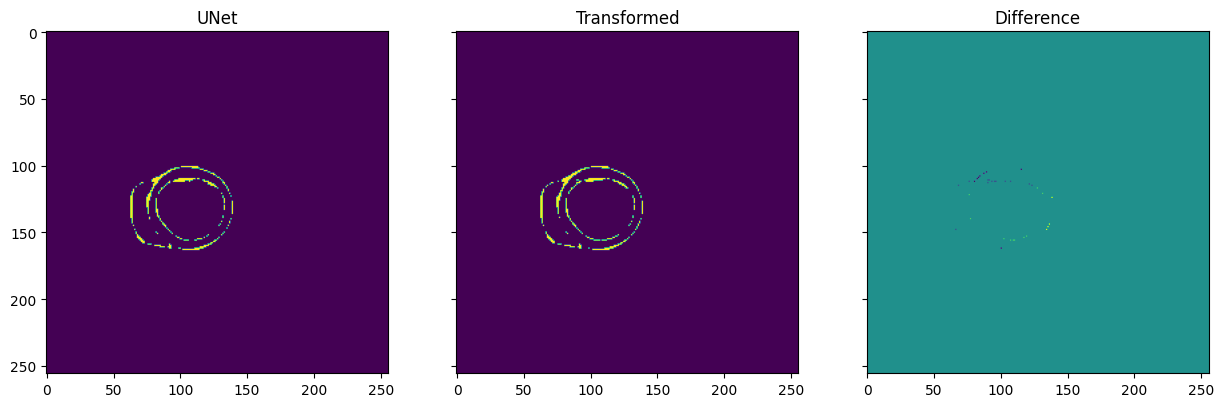

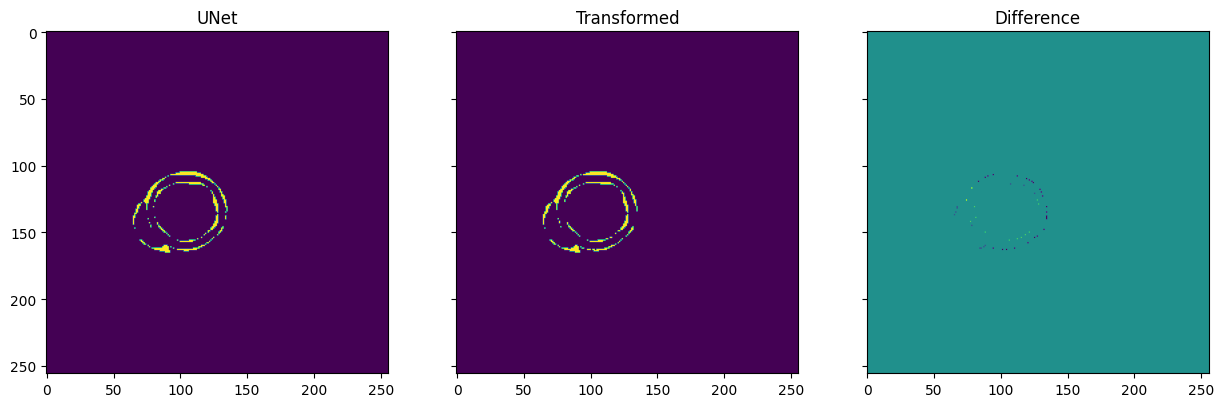

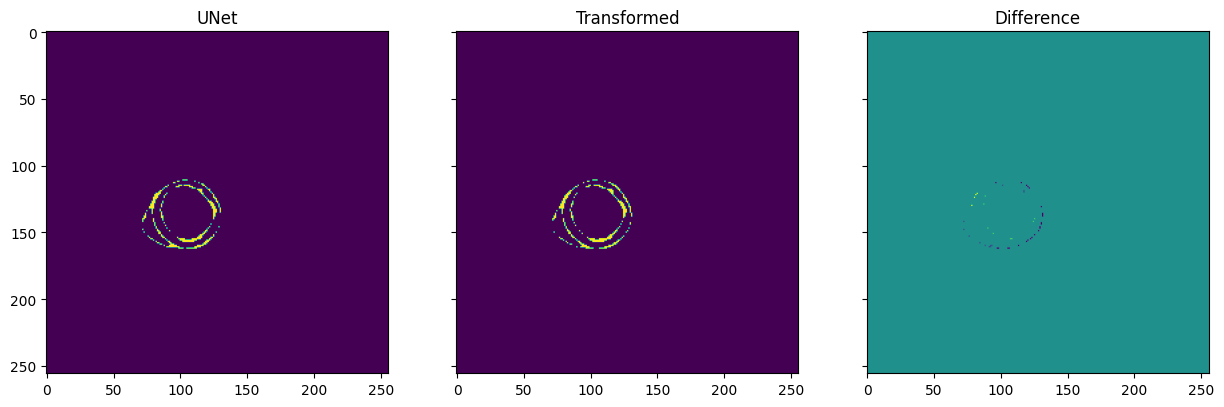

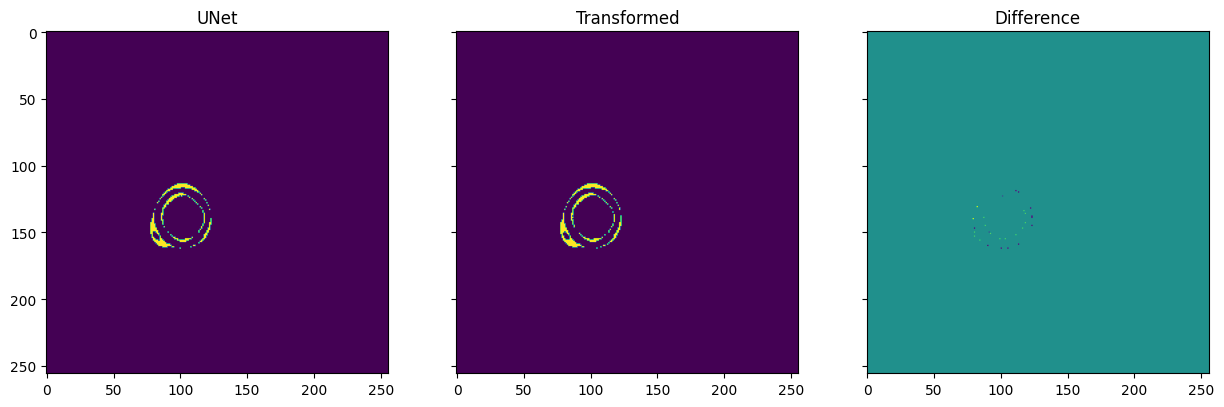

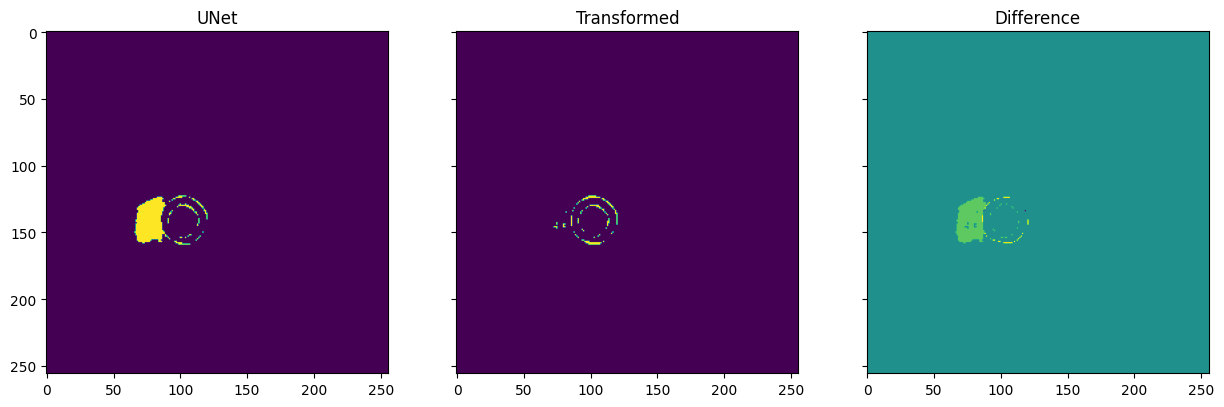

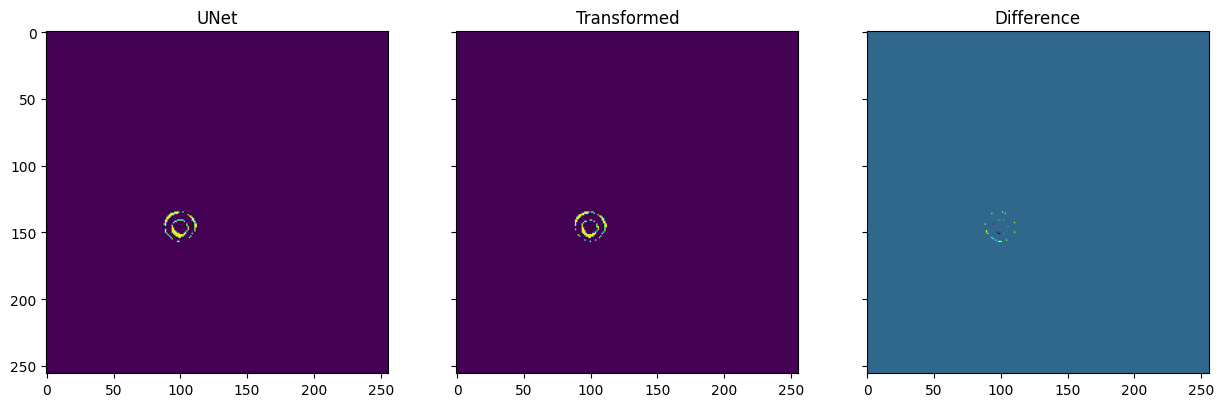

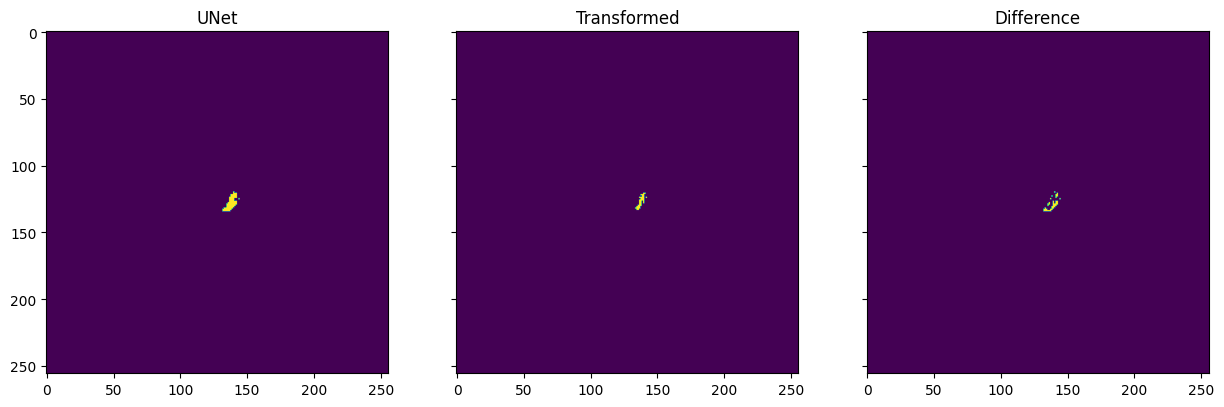

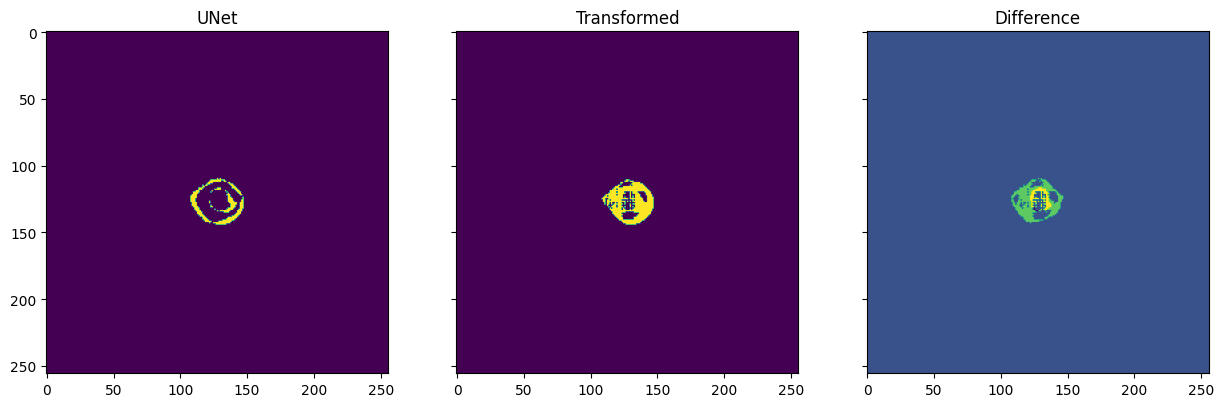

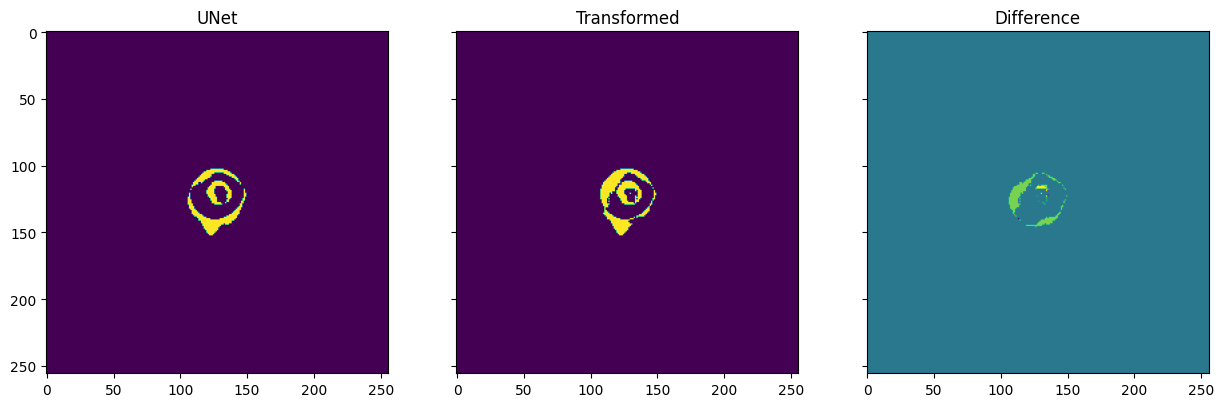

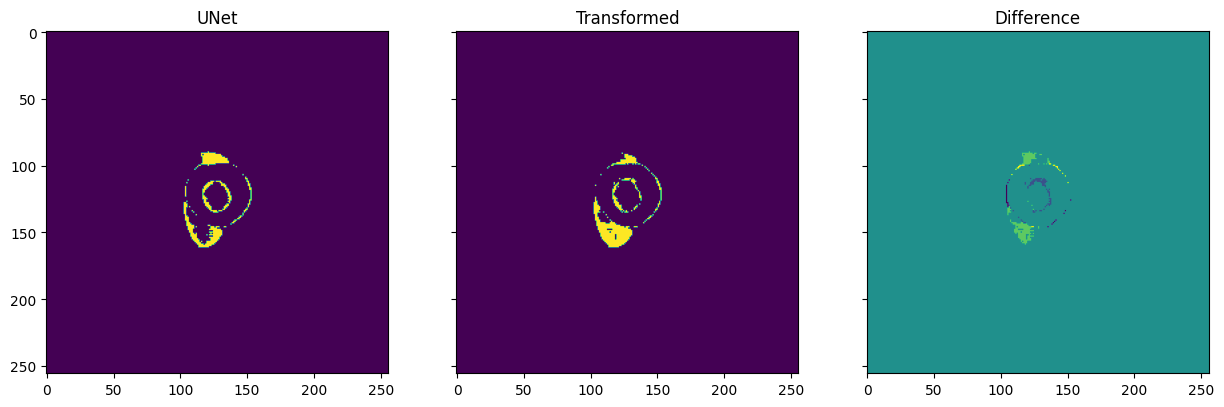

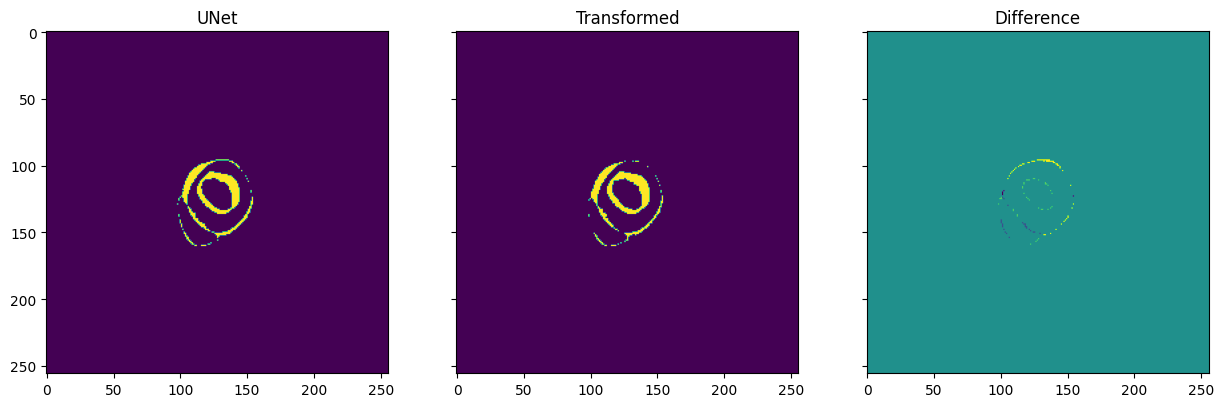

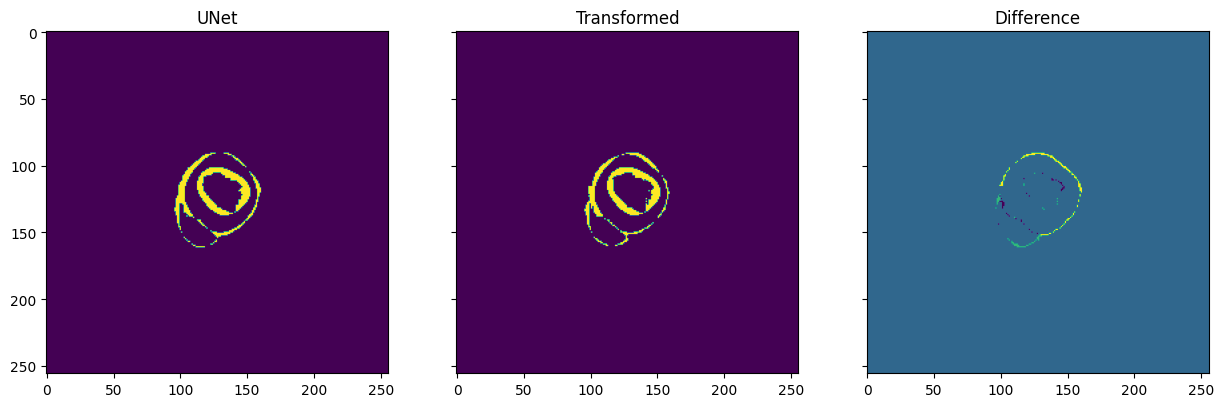

In [144]:
fig, axes = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)
for idx in range(1, 32):

    fig, axes = plt.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True)

    axes[0].imshow(out_unet[idx].detach().cpu() != target[idx].detach().cpu())
    axes[0].set_title('UNet')
    axes[1].imshow(out_transformed[idx].detach().cpu()!= target[idx].detach().cpu())
    axes[1].set_title('Transformed')
    axes[2].imshow((out_unet - out_transformed)[idx].detach().cpu())
    axes[2].set_title('Difference')

    plt.show()

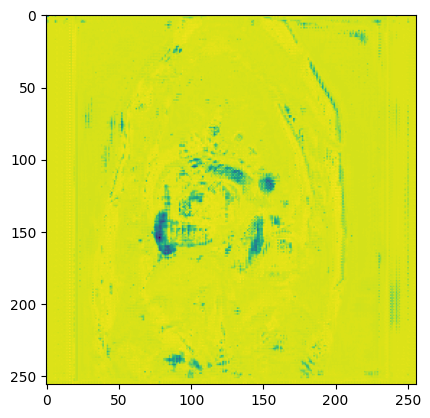

In [66]:
plt.imshow(out_transformed[0,0].detach().cpu().numpy())
plt.imshow(out_transformed[0,0].detach().cpu().numpy())

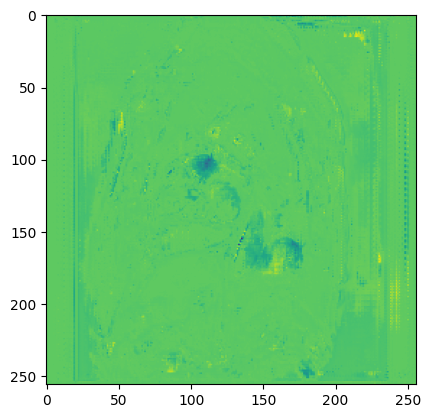

In [65]:
plt.imshow(out_unet[10,0].detach().cpu().numpy() - out_transformed[10,0].detach().cpu().numpy())

In [80]:
torch.unique(out_unet[23])

tensor([0, 1, 2, 3], device='cuda:0')

In [77]:
out_unet

torch.Size([32, 256, 256])

In [86]:
train_res = []
for batch in loaders['train']:
    x = batch['input'].to(device)
    _ = batchnorm_wrapper(x)
    tmp = batchnorm_wrapper.aggregate_adapter_scores()
    # tmp = torch.cat(
    #     [adapter.batch_distances for adapter in batchnorm_wrapper.adapters],
    #     dim=1
    # )
    train_res.append(tmp)

train_res = torch.cat(train_res, dim=0)
print(train_res.mean().item())

0.4414999783039093


In [78]:
val_res = []

for batch in loaders['val']:
    x = batch['input'].to(device)
    _ = batchnorm_wrapper(x)
    tmp = torch.cat(
        [adapter.batch_distances for adapter in batchnorm_wrapper.adapters],
        dim=1
    )
    val_res.append(tmp.sum(1).sqrt())

val_res = torch.cat(val_res, dim=0)
print(val_res.mean().item())

7.094884395599365


In [79]:
A_res = []
for batch in loaders['A']:
    x = batch['input'].to(device)
    _ = batchnorm_wrapper(x)
    tmp = torch.cat(
        [adapter.batch_distances for adapter in batchnorm_wrapper.adapters],
        dim=1
    )
    A_res.append(tmp.sum(1).sqrt())

A_res = torch.cat(A_res, dim=0)
print(A_res.mean().item()) 

7.669857025146484


In [76]:
tmp = {
    adapter.swivel: adapter.batch_distances.cpu()
    for adapter in batchnorm_wrapper.adapters
}

In [55]:
concatenated_tensor = torch.stack(list(tmp.values()), dim=2)
print(concatenated_tensor.shape)


RuntimeError: stack expects each tensor to be equal size, but got [32, 8] at entry 0 and [32, 16] at entry 6

In [44]:
summed_dists = torch.cat([s.sum((1,2)) for s in list(tmp.values())])
dist = torch.sqrt(summed_dists)

In [47]:
[s.sum((1,2)) for s in list(tmp.values())][0].shape

torch.Size([32])

In [64]:
torch.cat(list(tmp.values()), dim=1).shape

torch.Size([32, 1416])

In [19]:
# examples and debugging
device = 'cuda:0'
unet.to(device)

detector = BatchNormMahalanobisDetector(
    swivel='up3.0.conv_path.0.bn',
    device=device,
)
detector.train()
wrapper = BatchNormMahalanobisWrapper(
    model=unet,
    adapters=nn.ModuleList([detector])
)

wrapper.hook_adapters()
wrapper.eval()

loaders = {
    domain: DataLoader(
        raw_data[domain], 
        batch_size=32, 
        shuffle=False, 
        drop_last=False
    ) for domain in raw_data
}

torch.Size([64]) torch.Size([64]) BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
weight Parameter containing:
tensor([0.9421, 1.0805, 0.8742, 0.9576, 1.0234, 0.8998, 1.0170, 1.0217, 0.9900,
        1.1487, 0.9839, 0.8994, 1.2447, 0.7498, 0.8247, 1.0991, 0.9270, 1.0425,
        1.2085, 0.9339, 1.0053, 0.9170, 0.8475, 1.0271, 0.9268, 1.0854, 1.0127,
        1.1601, 0.9807, 0.9608, 1.0468, 0.9743, 0.9624, 1.1497, 1.0056, 1.0111,
        1.0037, 1.1796, 1.1302, 0.9974, 0.9350, 0.9601, 0.9943, 0.9731, 1.1043,
        1.0669, 1.0679, 0.9736, 1.0503, 0.9625, 0.9887, 0.8974, 1.0514, 1.0001,
        0.9660, 0.9252, 0.7543, 1.0787, 0.9455, 0.9483, 1.0084, 0.8573, 1.1100,
        0.9504], device='cuda:0', requires_grad=True)
bias Parameter containing:
tensor([-0.1934, -0.1042, -0.1345, -0.2009, -0.1762, -0.1494, -0.2315,  0.0014,
        -0.1883, -0.0403, -0.0157, -0.1885, -0.0117, -0.3748, -0.1752, -0.1132,
        -0.1633, -0.0425, -0.0628, -0.1744, -0.1306, -0.

In [31]:

detector.eval()
metrics = {domain: [] for domain in raw_data}
metrics['true_train'] = []
for _ in tqdm.tqdm(range(100)):
    batch = next(train_loader)
    x = batch['data']
    _ = wrapper(x.to(device))
    metrics['true_train'].append(detector.batch_distances.squeeze().cpu())

metrics['true_val'] = []
for _ in tqdm.tqdm(range(100)):
    batch = next(val_loader)
    x = batch['data'].to(device)
    _ = wrapper(x)
    metrics['true_val'].append(detector.batch_distances.squeeze().cpu())

for domain in raw_data:
    for batch in loaders[domain]:
        x = batch['input'].to(device)
        _ = wrapper(x)
        metrics[domain].append(detector.batch_distances.squeeze().cpu())
for domain in metrics:
    metrics[domain] = torch.cat(metrics[domain], dim=0)

100%|██████████| 100/100 [00:06<00:00, 15.09it/s]


In [33]:
print('Domain    Distance')
for domain in metrics:
    print(
        f'{domain.ljust(10)} {metrics[domain].mean().item():.3f}'
    )

Domain    Distance
train      0.940
val        0.925
A          0.865
true_train 0.936
true_val   0.914


### Slice Wise uncertainty Measures

Accuracy-Rejection (or [E]-AURC) get it from here: https://github.com/IML-DKFZ/values/blob/main/evaluation/metrics/aurc.py

AUROC 


In [35]:

def rc_curve_stats(
    risks: np.array, confids: np.array
) -> Tuple[List[float], List[float], List[float]]:
    coverages = []
    selective_risks = []
    assert (
        len(risks.shape) == 1 and len(confids.shape) == 1 and len(risks) == len(confids)
    )

    n_samples = len(risks)
    idx_sorted = np.argsort(confids)

    coverage = n_samples
    error_sum = sum(risks[idx_sorted])

    coverages.append(coverage / n_samples)
    selective_risks.append(error_sum / n_samples)

    weights = []

    tmp_weight = 0
    for i in range(0, len(idx_sorted) - 1):
        coverage = coverage - 1
        error_sum = error_sum - risks[idx_sorted[i]]
        tmp_weight += 1
        if i == 0 or confids[idx_sorted[i]] != confids[idx_sorted[i - 1]]:
            coverages.append(coverage / n_samples)
            selective_risks.append(error_sum / (n_samples - 1 - i))
            weights.append(tmp_weight / n_samples)
            tmp_weight = 0

    # add a well-defined final point to the RC-curve.
    if tmp_weight > 0:
        coverages.append(0)
        selective_risks.append(selective_risks[-1])
        weights.append(tmp_weight / n_samples)

    return coverages, selective_risks, weights


def aurc(risks: np.array, confids: np.array):
    _, risks, weights = rc_curve_stats(risks, confids)
    return sum(
        [(risks[i] + risks[i + 1]) * 0.5 * weights[i] for i in range(len(weights))]
    )


def eaurc(risks: np.array, confids: np.array):
    """Compute normalized AURC, i.e. subtract AURC of optimal CSF (given fixed risks)."""
    n = len(risks)
    # optimal confidence sorts risk. Asencding here because we start from coverage 1/n
    selective_risks = np.sort(risks).cumsum() / np.arange(1, n + 1)
    aurc_opt = selective_risks.sum() / n
    return aurc(risks, confids) - aurc_opt

In [33]:
from torchmetrics import (
    SpearmanCorrCoef, 
    AUROC,
    ROC
)
from torchmetrics.utilities.compute import _auc_compute_without_check

class AUROC(nn.Module):
    def __init__(
        self, 
        ret_curves: bool = True
    ):
        super().__init__()
        # args
        self.ret_curves = ret_curves
        # metrics
        self.roc_values = ROC(task='binary')


    def auroc(
        self,
        confids: Tensor,
        target: Tensor
    ):
        fpr, tpr, _ = self.roc_values(
            confids,
            target
        )

        ret = _auc_compute_without_check(
            x=fpr,
            y=tpr,
            direction=1.0
        )

        if self.ret_curves:
            return ret, fpr, tpr
        else:
            return ret


    def forward(
        self,
        confids: Tensor,
        target: Tensor
    ):
        return self.auroc(confids=confids, target=target)



class EAURC(nn.Module):
    def __init__(
        self,
        ret_curves: bool = True
    ):
        super().__init__()
        # args
        self.ret_curves = ret_curves
        
    
    def rc_curve_stats(
        self,
        confids: np.array, 
        risks: np.array
    ) -> Tuple[List[float], List[float], List[float]]:
        coverages = []
        selective_risks = []
        assert (
            len(risks.shape) == 1 and len(confids.shape) == 1 and len(risks) == len(confids)
        )

        n_samples = len(risks)
        idx_sorted = np.argsort(confids)

        coverage = n_samples
        error_sum = sum(risks[idx_sorted])

        coverages.append(coverage / n_samples)
        selective_risks.append(error_sum / n_samples)

        weights = []

        tmp_weight = 0
        for i in range(0, len(idx_sorted) - 1):
            coverage = coverage - 1
            error_sum = error_sum - risks[idx_sorted[i]]
            tmp_weight += 1
            if i == 0 or confids[idx_sorted[i]] != confids[idx_sorted[i - 1]]:
                coverages.append(coverage / n_samples)
                selective_risks.append(error_sum / (n_samples - 1 - i))
                weights.append(tmp_weight / n_samples)
                tmp_weight = 0

        # add a well-defined final point to the RC-curve.
        if tmp_weight > 0:
            coverages.append(0)
            selective_risks.append(selective_risks[-1])
            weights.append(tmp_weight / n_samples)

        return coverages, selective_risks, weights


    def aurc(
        self,
        confids: np.array, 
        risks: np.array
    ):
        _, risks, weights = self.rc_curve_stats(confids=confids, risks=risks)

        ret = sum(
            [(risks[i] + risks[i + 1]) * 0.5 * weights[i] for i in range(len(weights))]
        )

        if self.ret_curves:
            return ret, risks, weights
        else:
            return ret


    def eaurc(
        self,
        confids: Tensor, 
        risks: Tensor
    ):
        """Compute normalized AURC, i.e. subtract AURC of optimal CSF (given fixed risks)."""
        n = len(risks)
        confids = confids.numpy()
        risks = risks.numpy()
        # optimal confidence sorts risk. Asencding here because we start from coverage 1/n
        selective_risks = np.sort(risks).cumsum() / np.arange(1, n + 1)
        aurc_opt = selective_risks.sum() / n
        ret, risks, weights = self.aurc(confids=confids, risks=risks)
        if self.ret_curves:
            
            return ret - aurc_opt, ret, torch.Tensor(risks), torch.Tensor(weights)
        else:
            return ret - aurc_opt, ret


    def forward(
        self,
        confids: Tensor,
        risks: Tensor
    ):
        return self.eaurc(confids=confids, risks=risks)

In [34]:
risks = torch.rand(1000)
confids = torch.rand(1000)
##
# TODO:
# AUROC needs confidence + binary error PER PIXEL
# EAURC needs confidence + Dice PER SLICE
eaurc = EAURC()
auroc = AUROC()

eaurc_res, aurc_res, eaurc_risks, eaurc_weights = eaurc(confids=confids, risks=risks)

In [35]:
eaurc_res, aurc_res, eaurc_risks, eaurc_weights = eaurc(confids=confids, risks=risks)
auroc_res, auroc_fpr, auroc_tpr = auroc(confids=confids, target=(risks>0.8)*1)

In [36]:
auroc_res

tensor(0.4877)

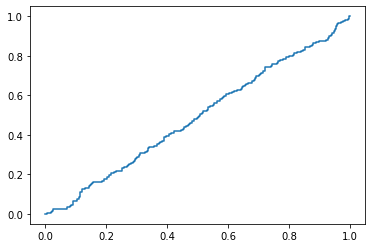

In [37]:
plt.plot(auroc_fpr, auroc_tpr)